In [5]:
#from keras.layers import UpSampling2D, Reshape, Activation, Conv2D, BatchNormalization, LeakyReLU, Input, Flatten, multiply
#from keras.layers import Dense, Embedding, Dropout, Concatenate, Conv2DTranspose
#from keras.models import Sequential, Model
#from tensorflow.keras.optimizers import Adam

import tensorflow as tf
#from tensorflow.keras import layers as layers
import pandas as pd
import tqdm as tqdm
import numpy as np
import imghdr
from PIL import Image
import matplotlib.pyplot as plt
import time
import os


import seaborn as sns
sns.set_theme(font_scale=1.6, style='whitegrid') 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
types = ['Grass', 'Fire', 'Water']
allowed_img_types = ['jpeg', 'png', 'jpg']

IMG_SIZE = 64
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32
Z_DIM = 100
NUM_CLASSES = 3

poke_img_path  = 'Poke_img'
poke_stat_path = 'Poke_stat'

#pokemon_data = pd.read_csv('Poke_stat/pokemon.csv')
#pokemon_data.head(2)

In [ ]:
clean_poke_types('pokemon', pokemon_data)

In [7]:
os.system('rm -r Poke_img/*')
os.system('cp -r pokemon/* Poke_img/')
clean_poke_types(poke_img_path, pokemon_data)

Removed  0  non Grass/Fire/Water pokemon's directory


## Image preprocessing

In [9]:
white_bg = []

def find_white_background(imgpath, cutoff = 0.25):
    """
    Analysis of the background in order to keep only images with white bg
    Args:
        imgpath: path to the folders containing pokemon's images
        cutoff: percentage of white pixel which denotes that yes, the image has white bg (default 0.2)
    Returns:
        Boolean value representing two classes: yes or no! There is/isn't a white bg
    """
    white_pixels = 0
    img = Image.open(imgpath).convert('RGBA')
    img_data = img.getdata()
    for i in range(img.size[0]*img.size[1]):
            if(img_data[i][0] == 255 and img_data[i][1] == 255 and img_data[i][2] == 255):
                white_pixels += 1.
    white_percent = white_pixels/(img.size[0]*img.size[1])
    if(white_percent >= cutoff):
        return True
    else:
        return False
    
    
def select_9types_pokemon(dirpath, ds_stat):
    pokemon_names = []
    pokemon_types = []
    for _ in range(len(ds_stat)):
        if ds_stat['Type1'][_] in types:
            pokemon_names.append(ds_stat['Name'][_])
            pokemon_types.append(ds_stat['Type1'][_])
    return pokemon_names, pokemon_types



def standardize_images(img_size, img_types, dirpath):
    removed = 0
    for directory in tqdm.tqdm(os.listdir(dirpath)):
        poke_counter = 0
        for img in os.listdir(dirpath + '/' + directory):
            img_path = dirpath + '/' + directory + '/' + img
            if(imghdr.what(img_path) not in allowed_img_types):
                os.system('rm '+ img_path)
                removed += 1
            else:    
                image = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE)).convert('RGBA')
                new_image = Image.new("RGBA", (IMG_SIZE, IMG_SIZE), "WHITE")
                new_image.paste(image, (0, 0), image)                          
                poke_counter += 1
                os.system('rm ' + img_path)
                new_path = dirpath + "/" + directory + "/" + str(directory.lower()) + str(poke_counter) + '.png'
                new_image.save(new_path, 'PNG', quality=90)
            
    print('Removed ', removed, " images not *png or *jpeg and resized all the survived as (48, 48, 3)")



def clean_poke_types(dirpath, ds_stat):
    os.system('mkdir Poke_img/Grass')
    os.system('mkdir Poke_img/Water')
    os.system('mkdir Poke_img/Fire')

    removed = 0
    poke_names, poke_types = select_9types_pokemon(dirpath, ds_stat)
    for directory in os.listdir(dirpath):
        if(directory not in types):
            if(directory.lower() not in poke_names):
                os.system('rm -r ' + dirpath + "/" + directory)
                removed += 1
            else:
                poke_idx  = poke_names.index(directory.lower())
                this_type = poke_types[poke_idx]
                os.system('mv Poke_img/' + directory + "/* Poke_img/" + this_type)
                os.system('rm -r Poke_img/' + directory)
    print('Removed ', removed, " non Grass/Fire/Water pokemon's directory")
            
    
def only_big_folders(dirpath):
    for directory in os.listdir(dirpath):
        if(len(os.listdir(dirpath + "/" + directory))<=15):
            os.system('rm -r ' + dirpath + "/" + directory)
            
        
    
def clean_backgrounds(dirpath):
    removed = 0
    for directory in tqdm.tqdm(os.listdir(dirpath)):
        for image in os.listdir(dirpath + "/" + directory):
            img_path = dirpath + "/" + directory + "/" + image
            is_white = find_white_background(img_path)
            if (is_white == False):
                os.system("rm " + img_path)
                removed += 1
    print('Removed ', removed, " images without white bg")

In [5]:
poke_names, poke_types = select_9types_pokemon(poke_stat_path, pokemon_data)
print(poke_names[20], poke_types[20])
#poke_names

poliwrath Water


In [10]:
standardize_images(IMG_SIZE, allowed_img_types, poke_img_path)

100%|█████████████████████████████████████████████████████████████████| 3/3 [01:32<00:00, 30.85s/it]

Removed  208  images not *png or *jpeg and resized all the survived as (48, 48, 3)


In [11]:
clean_backgrounds(poke_img_path)

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.54s/it]

Removed  2450  images without white bg


In [24]:
def show_random_sample(dataset):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(20):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.tight_layout()
    plt.savefig('exsample.pdf')
    plt.show()
    
    
def predict_random_sample(dataset, cnn):
    plt.figure(figsize=(12, 5))
    for images, labels in dataset.take(1):
        predictions = cnn.predict(images)
        for i in range(10):
            if(class_names[np.argmax(predictions[i])] != class_names[labels[i]]): 
                color = 'red'
            else:
                color = 'blue'
            ax = plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            title_obj = plt.title(class_names[np.argmax(predictions[i])])
            plt.setp(title_obj, color=color)
            plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    
def plot_history(history):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.title('Loss function: train VS valid')
    plt.plot(history.history['loss'], color='red', ls='--', lw=2, label='Train loss')
    plt.plot(history.history['val_loss'], color='red', ls='-', lw=5, label='Valid loss', alpha=0.7)
    plt.xlabel('epoch')
    plt.ylabel('Loss value')
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy: train VS valid')
    plt.plot(history.history['accuracy'], color='blue', ls='--', lw=2, label='Train loss')
    plt.plot(history.history['val_accuracy'], color='blue', ls='-', lw=5, label='Valid loss', alpha=0.7)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy value')
    plt.legend()
    plt.show()
    
    
def generate_and_save_images(generator, discriminator, epoch, test_input):
    predictions = generator(test_input, training=True)
    images = []
    for i in range(predictions.shape[0]):
        images.append(tf.keras.preprocessing.image.array_to_img(predictions[i]))
    decisions = discriminator(predictions)

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title(f"{decisions.numpy()[i,0]:.2f}")
        plt.axis('off')
    plt.savefig('Generated/image_at_epoch_{:04d}.png'.format(epoch))

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    poke_img_path,
    validation_split=0.4,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)


val_dataset = tf.keras.utils.image_dataset_from_directory(
    poke_img_path,
    validation_split=0.4,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)


data_augmentation = tf.keras.models.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMG_SIZE, IMG_SIZE,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)


train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)



NameError: name 'tf' is not defined

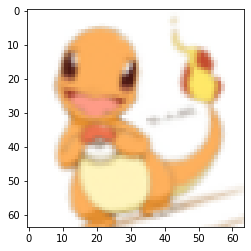

In [11]:
for img, lab in train_ds.take(1):
    img_np = img.numpy()
    lab_np = lab.numpy()
    
img_np = img_np / 255.
    
aug = data_augmentation(img_np)

plt.imshow(aug[3])

In [15]:
class_names = val_dataset.class_names
num_classes = len(class_names)
print(class_names, len(class_names))

['Fire', 'Grass', 'Water'] 3


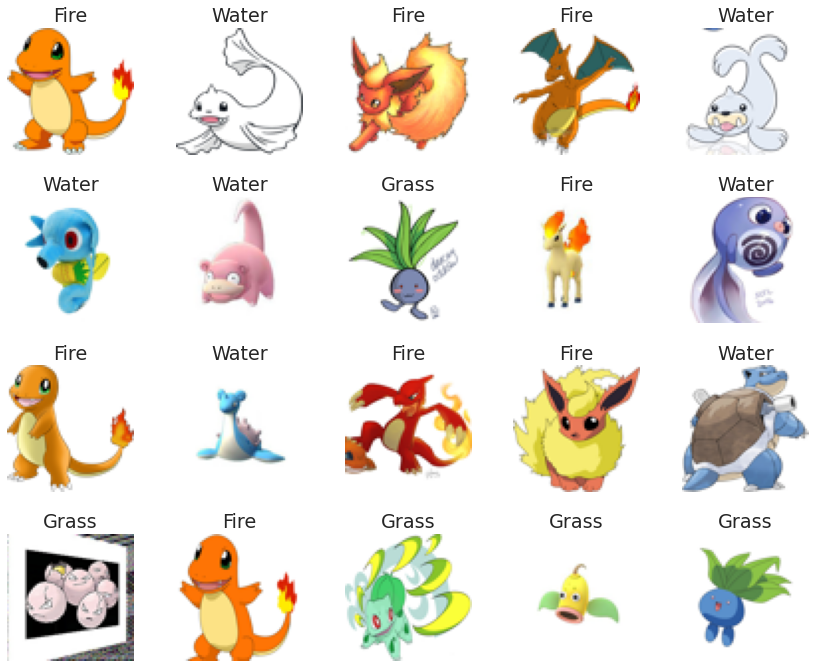

In [25]:
show_random_sample(train_dataset)

In [72]:
def pokeClassificator():

    model = tf.keras.models.Sequential(name='PokeCNN')

    model.add(tf.keras.layers.Rescaling(1./255, input_shape=INPUT_SHAPE))
    model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',
                                     input_shape=INPUT_SHAPE ,activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same', 
                                     input_shape=INPUT_SHAPE, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',
                                     input_shape=INPUT_SHAPE, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32,activation='tanh'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Dense(32,activation='tanh'))
    model.add(tf.keras.layers.Dense(num_classes))

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer='Adam', metrics=['accuracy'])

    return model

test_cnn = pokeClassificator()
test_cnn.summary()

Model: "PokeCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 32)        1846

In [73]:
results = test_cnn.fit(train_ds, epochs=10, validation_data=val_ds, verbose=1)

Epoch 1/10
20/20 [==============================] - 7s 305ms/step - loss: 1.0422 - accuracy: 0.4977 - val_loss: 0.8284 - val_accuracy: 0.6235
Epoch 2/10
20/20 [==============================] - 6s 291ms/step - loss: 0.8415 - accuracy: 0.6338 - val_loss: 0.7555 - val_accuracy: 0.6518
Epoch 3/10
20/20 [==============================] - 6s 292ms/step - loss: 0.7024 - accuracy: 0.7136 - val_loss: 0.6668 - val_accuracy: 0.7506
Epoch 4/10
20/20 [==============================] - 6s 293ms/step - loss: 0.6821 - accuracy: 0.7121 - val_loss: 0.6190 - val_accuracy: 0.8024
Epoch 5/10
20/20 [==============================] - 6s 293ms/step - loss: 0.5975 - accuracy: 0.7590 - val_loss: 0.5137 - val_accuracy: 0.8400
Epoch 6/10
20/20 [==============================] - 6s 295ms/step - loss: 0.5563 - accuracy: 0.7934 - val_loss: 0.4872 - val_accuracy: 0.8188
Epoch 7/10
20/20 [==============================] - 6s 295ms/step - loss: 0.4716 - accuracy: 0.8435 - val_loss: 0.3841 - val_accuracy: 0.8494
Epoch 

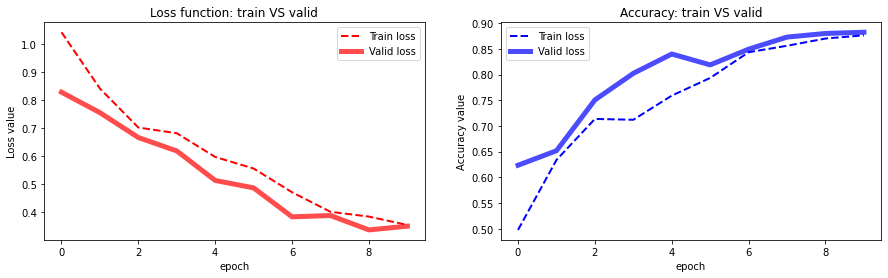

In [74]:
plot_history(results)

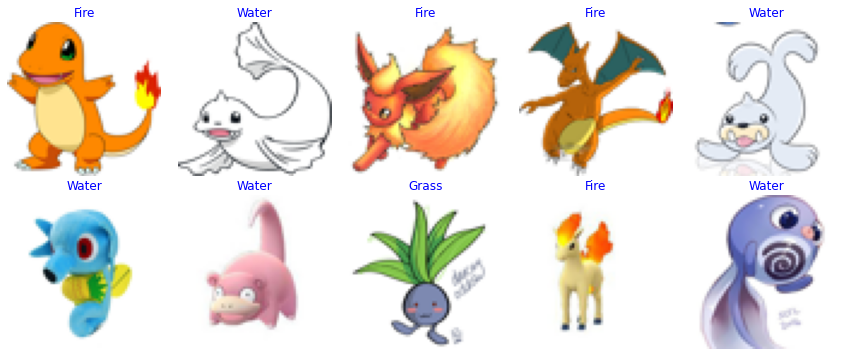

In [80]:
predict_random_sample(train_dataset, test_cnn)

In [14]:
cgan_dataset = tf.keras.utils.image_dataset_from_directory(
    poke_img_path,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

cgan_ds = cgan_dataset.cache().shuffle(1000).prefetch(buffer_size=1064)

Found 1064 files belonging to 3 classes.
